# Gulf of Maine SST Anomaly Trend Analysis (2003-2024)

This notebook reads a PO.DAAC Sea Surface Temperature Virtual Data Store (VDS), subsets the data for the Gulf of Maine region, and calculates the pixel-by-pixel decadal trend for SST anomalies.


In [29]:
# Import necessary libraries
import earthaccess
import fsspec
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Configure matplotlib for inline plotting
%matplotlib inline

In [31]:
# Authenticate with Earthdata Login (interactive)
auth = earthaccess.login()

In [32]:
# Mapper subroutine 

def get_vds_mapper(vds_link, in_cloud_region=False):
    """
    Produces a virtual dataset mapper that can be passed to xarray.
    
    Parameters:
    - vds_link: URL to the virtual JSON file.
    - in_cloud_region: Boolean, set to True if running in AWS us-west-2.
    """
    if in_cloud_region:
        # Use S3 filesystem if running in the correct AWS region (us-west-2 for PO.DAAC)
        fs_data = earthaccess.get_s3_filesystem(daac="PODAAC")
        remote_protocol = "s3"
    else:
        # Use HTTPS filesystem for local execution
        fs_data = earthaccess.get_fsspec_https_session()
        remote_protocol = "https"
    
    storage_opts = {
        "fo": vds_link, 
        "remote_protocol": remote_protocol, 
        "remote_options": fs_data.storage_options
    }
    # Create the reference filesystem
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    return fs_ref.get_mapper('')


In [33]:
# Configuration Parameters

# Virtual Dataset URL
vds_url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/MUR25-JPL-L4-GLOB-v04.2/MUR25-JPL-L4-GLOB-v04.2_virtual_https.json"

# Gulf of Maine Bounding Box
# Approx: 41N to 46N, -72W to -65W
lat_min, lat_max = 39.0, 47.0
lon_min, lon_max = -72.0, -55.0

# Time Range
start_date = "2003-01-01"
end_date = "2024-12-31"

In [34]:
# Open Dataset and Subset (lazy load)

# Create the mapper (assuming local execution, set in_cloud_region=True if on AWS)
mapper = get_vds_mapper(vds_url, in_cloud_region=False)

# Open the dataset lazily using Xarray and the Zarr engine
print(f"Opening dataset...")
sst_ds = xr.open_dataset(mapper, engine="zarr", chunks={}, consolidated=False)

# Subset the data for variable sst_anomaly
sst_anom_subset = sst_ds['sst_anomaly'].sel(
    time=slice(start_date, end_date),
    lat=slice(lat_min, lat_max),
    lon=slice(lon_min, lon_max)
)
sst_anom_subset

Opening dataset...


<xarray.DataArray 'sst_anomaly' (time: 8036, lat: 32, lon: 68)> Size: 140MB
dask.array<getitem, shape=(8036, 32, 68), dtype=float64, chunksize=(1, 32, 68), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 128B 39.12 39.38 39.62 39.88 ... 46.38 46.62 46.88
  * lon      (lon) float32 272B -71.88 -71.62 -71.38 ... -55.62 -55.38 -55.12
  * time     (time) datetime64[ns] 64kB 2003-01-01T09:00:00 ... 2024-12-31T09...
Attributes:
    long_name:              SST anomaly from a seasonal SST climatology based...
    coverage_content_type:  auxiliaryInformation
    units:                  kelvin
    valid_min:              -32767
    valid_max:              32767
    comment:                anomaly reference to the day-of-year average betw...

In [35]:
# Calculation: Decadal Trend
# Note: This step triggers data loading and intensive computation.

print("Loading data into memory...")
sst_anom_subset = sst_anom_subset.load()

print("Calculating linear trend (polyfit)...")
# Calculate the linear trend (degree=1) along the time dimension
# Result units: [variable units] per nanosecond
polyfit_result = sst_subset.polyfit(dim="time", deg=1)
slope = polyfit_result.polyfit_coefficients.sel(degree=1)

# Convert slope to degrees Celsius per Decade
# 1 year ~ 3.15576e16 nanoseconds
ns_per_year = 1e9 * 60 * 60 * 24 * 365.25
years_per_decade = 10

trend_decadal = slope * ns_per_year * years_per_decade

print("Done")


Loading data into memory...
Calculating linear trend (polyfit)...
Done


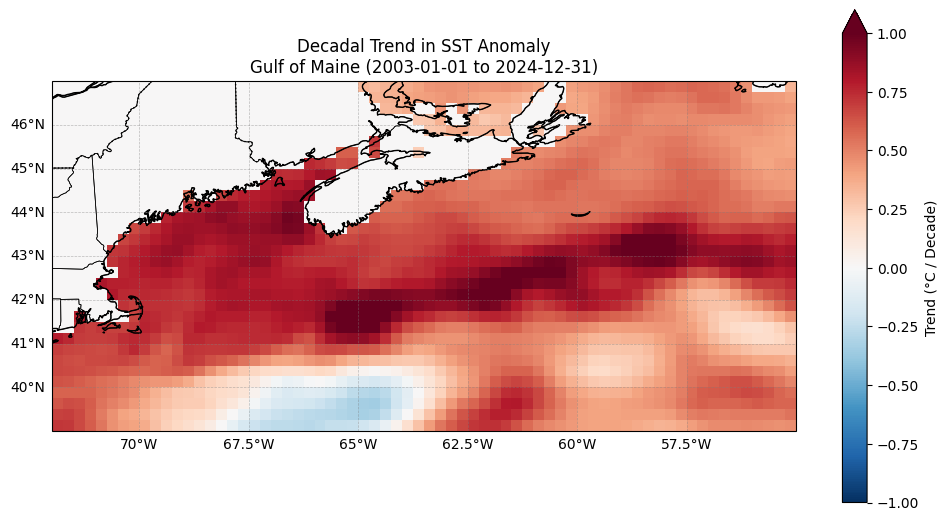

In [36]:
# Visualization: Plot the Trend

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot data
trend_plot = trend_decadal.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    cbar_kwargs={
        'label': 'Trend (°C / Decade)', 
        'orientation': 'vertical',
        'shrink': 0.8
    },
    vmin=-1.0, 
    vmax=1.0
)

# Set extent and gridlines
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title(f'Decadal Trend in SST Anomaly\nGulf of Maine ({start_date} to {end_date})')
plt.show()